# **Análise Exploratória de Dados de Logística**

## 1\. Contexto

Como parte do desenvolvimento do curso de **Analista de Dados** da **EBAC**, esse é o primeiro projeto referente a **Análise Exploratória de Dados em Python**, onde estamos analisando os dados de entrega do **Distrito Federal** **(DF)** disponibilizado pelo professor **Andre Marcos Perez** através dos dados **Loggi** uma startup unicórnio brasileira de tecnologia focada em logística

[Repositorio GitHub da Loggi](https://github.com/loggi/loggibud)

[Base disponibilizada pelo professor Andre Marcos Perez](https://github.com/andre-marcos-perez/ebac-course-utils/blob/main/dataset/deliveries.json)

## 2\. Pacotes e bibliotecas

In [ ]:
# Pacotes nativos Python
import json # Biblioteca para trabalhar com dados no formato JSON
import os # Modulo para interagir com o sistema operacional

#Pacote de terceiro
import pandas as pd # Biblioteca para analise de dados
import geopandas # Biblioteca para trabalhar com dados geoespaciais
import geopy # Biblioteca que fornece ferramentas para geocodificação (converter endereços em coordenadas) e outras operações geográficas
import numpy as np # Biblioteca que fornece suporte para arrays multidimensionais e operações matemáticas de alto nível
import matplotlib.pyplot as plt # Sub biblioteca do Matploylib que fornece funcionalidades para criar visualizações gráficas
import seaborn as sns # Biblioteca extensão da Matplotlib que fornece estilos estéticos adicionais e funções de plotagem de alto nível para visualizações estatísticas
from geopy.geocoders import Nominatim # Classe da sub biblioteca geocoders do GeoPy que é um serviço de geocodificação baseado em OpenStreetMap
from geopy.extra.rate_limiter import RateLimiter # Classe da sub biblioteca extra do GeoPy que fornece uma função para limitar a taxa de solicitações a um serviço

## 3\. Exploração de dados

### **3.1 Importar os dados**

Os dados disponiveis no pela **Loggi** e tratato pelo professor **Andre Marcos Perez** estão em formato json conforme exemplo a seguir:

```
[
  {
    "name": "cvrp-0-df-0",
    "region": "df-0",
    "origin": {"lng": -47.802664728268745, "lat": -15.657013854445248},
    "vehicle_capacity": 180,
    "deliveries": [
      {
        "id": "ed0993f8cc70d998342f38ee827176dc",
        "point": {"lng": -47.7496622016347, "lat": -15.65879313293694},
        "size": 10
      },
      {
        "id": "c7220154adc7a3def8f0b2b8a42677a9",
        "point": {"lng": -47.75887552060412, "lat": -15.651440380492554},
        "size": 10
      },
      ...
    ]
  }
]
```

E para o projeto vamos trabalhar apenas com as informações **name**, **region**, **origin** e **deliveries**

In [ ]:
# Realizar o download do arquivo e carregar os dados em um dicionario Python
if os.path.exists('deliveries.json'):
  print("O arquivo deliveries.json já existe")

else:
  !wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries.json" -O deliveries.json
  print("Arquivo deliveries.json criado com sucesso")

with open('deliveries.json', mode='r', encoding='utf8') as file:
  Dados = json.load(file)

O arquivo deliveries.json já existe


In [ ]:
# Criar um dataframe e consultar os dados disponiveis no data frame entregas_df
entregas_df = pd.DataFrame(Dados)
entregas_df = entregas_df[['name','region',	'origin',	'deliveries']]
entregas_df.head()

,name,region,origin,deliveries
0,cvrp-2-df-33,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'p..."
1,cvrp-2-df-73,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'bf3fc630b1c29601a4caf1bdd474b85', 'po..."
2,cvrp-2-df-20,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'b30f1145a2ba4e0b9ac0162b68d045c3', 'p..."
3,cvrp-1-df-71,df-1,"{'lng': -47.89366206897872, 'lat': -15.8051175...","[{'id': 'be3ed547394196c12c7c27c89ac74ed6', 'p..."
4,cvrp-2-df-87,df-2,"{'lng': -48.05498915846707, 'lat': -15.8381445...","[{'id': 'a6328fb4dc0654eb28a996a270b0f6e4', 'p..."


Temos 4 colunas com as seguintes informações:

 - **name**: uma `string` com o nome único da instância;
 - **region**: uma `string` com o nome único da região do **hub**;
 - **origin**: um `dict` com a latitude e longitude da região do **hub**;
 - **deliveries**: uma `list` de `dict` com as **entregas** que devem ser realizadas.

### **3.2 Tratar os dados da coluna origin**

Precisamos tratar a coluna **origin** criando novas colunas com a informação da **latitude** e **longitude**

In [ ]:
origem_hub = pd.json_normalize(entregas_df['origin'])
origem_hub.rename(columns={"lng": "hub_lng", "lat": "hub_lat"}, inplace=True)
origem_hub.head()

,hub_lng,hub_lat
0,-48.054989,-15.838145
1,-48.054989,-15.838145
2,-48.054989,-15.838145
3,-47.893662,-15.805118
4,-48.054989,-15.838145


### **3.3 Tratar os dados da coluna deliveries**

Precisamos tratar tambem a **deliveries** criando novas colunas com a informação da **latitude** e **longitude**, porém, como o **deliveries** possui mais informações vamos realizar uma tratativa um pouco diferente

In [ ]:
destino_explode = entregas_df[['deliveries']].explode('deliveries')
destino_explode.head()

,deliveries
0,"{'id': '313483a19d2f8d65cd5024c8d215cfbd', 'po..."
0,"{'id': '320c94b17aa685c939b3f3244c3099de', 'po..."
0,"{'id': '3663b42f4b8decb33059febaba46d5c8', 'po..."
0,"{'id': 'e11ab58363c38d6abc90d5fba87b7d7', 'poi..."
0,"{'id': '54cb45b7bbbd4e34e7150900f92d7f4b', 'po..."


In [ ]:
destino_entrega = pd.concat([
  pd.DataFrame(destino_explode["deliveries"].apply(lambda record: record["size"])).rename(columns={"deliveries": "delivery_size"}),
  pd.DataFrame(destino_explode["deliveries"].apply(lambda record: record["point"]["lng"])).rename(columns={"deliveries": "delivery_lng"}),
  pd.DataFrame(destino_explode["deliveries"].apply(lambda record: record["point"]["lat"])).rename(columns={"deliveries": "delivery_lat"}),
], axis= 1)

destino_entrega['index_value'] = destino_entrega.index

destino_entrega.head()

,delivery_size,delivery_lng,delivery_lat,index_value
0,9,-48.116189,-15.848929,0
0,2,-48.118195,-15.850772,0
0,1,-48.112483,-15.847871,0
0,2,-48.118023,-15.846471,0
0,7,-48.114898,-15.858055,0


### **3.4 Juntar os dados tratados**

Com os dados da **longitute** e **latitude** tratato referente a coluna **origin** e **deliveries** será nececessario juntar esses dados em um novo Data Frame

In [ ]:
entregas_tratato_df = entregas_df.drop(labels=['origin','deliveries'], axis=1)
entregas_tratato_df = pd.merge(left=entregas_tratato_df, right=origem_hub, how='inner', left_index=True, right_index=True)
entregas_tratato_df = pd.merge(left=entregas_tratato_df, right=destino_entrega, how='right', left_index=True, right_index=True)
entregas_tratato_df.reset_index(inplace=True, drop=True)
entregas_tratato_df.head()

,name,region,hub_lng,hub_lat,delivery_size,delivery_lng,delivery_lat,index_value
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,9,-48.116189,-15.848929,0
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,2,-48.118195,-15.850772,0
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,1,-48.112483,-15.847871,0
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,2,-48.118023,-15.846471,0
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,7,-48.114898,-15.858055,0


### **3.5 Estrutura do novo Data Frame**

Com o novo Data Frame criado, vamos enteder um pouco a sua estrutura

In [ ]:
print(f'Data Frame possui', entregas_tratato_df.shape[0], 'linha e', entregas_tratato_df.shape[1], 'colunas')

Data Frame possui 636149 linha e 8 colunas


In [ ]:
entregas_tratato_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636149 entries, 0 to 636148
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   name           636149 non-null  object 
 1   region         636149 non-null  object 
 2   hub_lng        636149 non-null  float64
 3   hub_lat        636149 non-null  float64
 4   delivery_size  636149 non-null  int64  
 5   delivery_lng   636149 non-null  float64
 6   delivery_lat   636149 non-null  float64
 7   index_value    636149 non-null  int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 38.8+ MB


## 4\. Manipulação

### **4.1 Geocodificação reversa - Hub**

Para ficar mais facil a analise, iremos tranformar as informações de **latitude** e **longitude** em **cidade** e **bairro** do **HUB** e para esse trabalho iremos usar o **OpenStreetMap** um projeto *open source* que mantem um serviço gratuito de geocodificação chamado [Nominatim](https://nominatim.org/) e utilizarmos através do pacote Python `geopy` para fazer a operação reversa.

 Obs.:
 O serviço Nominatim presenta como limitação a quantia de [uma única consuta por segundo](https://operations.osmfoundation.org/policies/nominatim/)

In [ ]:
# Criar um Data Framte com a localização do HUB
hub_df = entregas_tratato_df[["region", "hub_lng", "hub_lat"]]
hub_df = hub_df.drop_duplicates().sort_values(by="region").reset_index(drop=True)
hub_df.head()

,region,hub_lng,hub_lat
0,df-0,-47.802665,-15.657014
1,df-1,-47.893662,-15.805118
2,df-2,-48.054989,-15.838145


In [ ]:
# Retornar as informações da latitude e longitute do HUB
geolocator = Nominatim(user_agent="ebac_geocoder")
geocoder = RateLimiter(geolocator.reverse, min_delay_seconds=1)

hub_df["coordinates"] = hub_df["hub_lat"].astype(str)  + ", " + hub_df["hub_lng"].astype(str)
hub_df["geodata"] = hub_df["coordinates"].apply(geocoder)
hub_df.head()

,region,hub_lng,hub_lat,coordinates,geodata
0,df-0,-47.802665,-15.657014,"-15.657013854445248, -47.802664728268745","(Rua 7, Quadra 2, Sobradinho, Região Geográfic..."
1,df-1,-47.893662,-15.805118,"-15.80511751066334, -47.89366206897872","(SQS 303, Asa Sul, Brasília, Plano Piloto, Reg..."
2,df-2,-48.054989,-15.838145,"-15.83814451122274, -48.05498915846707","(Armazém do Bolo, lote 4/8, CSB 4/5, Taguating..."


In [ ]:
# Normalizar os dados referente a colina geodata
hub_geodata_df = pd.json_normalize(hub_df["geodata"].apply(lambda data: data.raw))

# Tratar os dados normalizado gerando um novo Data Frame
hub_geodata_df = hub_geodata_df[["address.town", "address.suburb", "address.city"]]
hub_geodata_df.rename(columns={"address.town": "hub_town", "address.suburb": "hub_suburb", "address.city": "hub_city"}, inplace=True)
hub_geodata_df["hub_city"] = np.where(hub_geodata_df["hub_city"].notna(), hub_geodata_df["hub_city"], hub_geodata_df["hub_town"])
hub_geodata_df["hub_suburb"] = np.where(hub_geodata_df["hub_suburb"].notna(), hub_geodata_df["hub_suburb"], hub_geodata_df["hub_city"])
hub_geodata_df = hub_geodata_df.drop("hub_town", axis=1)
hub_geodata_df.head()

,hub_suburb,hub_city
0,Sobradinho,Sobradinho
1,Asa Sul,Brasília
2,Taguatinga,Taguatinga


In [ ]:
hub_df = pd.merge(left=hub_df, right=hub_geodata_df, left_index=True, right_index=True)
hub_df = hub_df[["region", "hub_suburb", "hub_city"]]
hub_df.head()

,region,hub_suburb,hub_city
0,df-0,Sobradinho,Sobradinho
1,df-1,Asa Sul,Brasília
2,df-2,Taguatinga,Taguatinga


### **4.2 Geocodificação reversa - Entrega**

Para ficar mais facil a analise, iremos tranformar as informações de **latitude** e **longitude** em **cidade** e **bairro** das **Entregas**, porém, como temos muitos mais dados de **entrega** vamos usar a base disponibilidade pelo professor **Andre Marcos Perez**, pois se realizar o mesmo trabalhando feito para o HUb levariamos 7 dias para finalizar devido a limitação a consultar os dados no servidor do Nominatim.

In [ ]:
# Realizar o download do arquivo e carregar os dados em um Data Frame
if os.path.exists('deliveries-geodata.csv'):
  print("O arquivo deliveries-geodata.csv já existe")

else:
  !wget -q "https://raw.githubusercontent.com/andre-marcos-perez/ebac-course-utils/main/dataset/deliveries-geodata.csv" -O deliveries-geodata.csv
  print("Arquivo deliveries-geodata.csv criado com sucesso")

deliveries_geodata_df = pd.read_csv("deliveries-geodata.csv")
deliveries_geodata_df.head()

O arquivo deliveries-geodata.csv já existe


,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,-48.116189,-15.848929,Ceilândia,P Sul
1,-48.118195,-15.850772,Ceilândia,P Sul
2,-48.112483,-15.847871,Ceilândia,P Sul
3,-48.118023,-15.846471,Ceilândia,P Sul
4,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


### **4.3 Tratar o Data Frame original com as novas informações**

In [ ]:
entregas_fim_df = pd.merge(left=entregas_tratato_df, right=hub_df, how="inner", on="region")
entregas_fim_df = entregas_fim_df[["name", "region", "hub_lng", "hub_lat", "hub_city", "hub_suburb", "delivery_size", "delivery_lng", "delivery_lat"]]
entregas_fim_df = pd.merge(left=entregas_fim_df, right=deliveries_geodata_df[["delivery_city", "delivery_suburb"]], how="inner", left_index=True, right_index=True)
entregas_fim_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,9,-48.116189,-15.848929,Ceilândia,P Sul
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,2,-48.118195,-15.850772,Ceilândia,P Sul
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,1,-48.112483,-15.847871,Ceilândia,P Sul
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,2,-48.118023,-15.846471,Ceilândia,P Sul
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol


### **4.4 Qualidade dos dados**

Nessa etapa, iremos verificar a qualidade dos dados, ou seja, a consistência do seu `schema`, valores faltantes, etc

In [ ]:
entregas_fim_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 636149 entries, 0 to 636148
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   name             636149 non-null  object 
 1   region           636149 non-null  object 
 2   hub_lng          636149 non-null  float64
 3   hub_lat          636149 non-null  float64
 4   hub_city         636149 non-null  object 
 5   hub_suburb       636149 non-null  object 
 6   delivery_size    636149 non-null  int64  
 7   delivery_lng     636149 non-null  float64
 8   delivery_lat     636149 non-null  float64
 9   delivery_city    634447 non-null  object 
 10  delivery_suburb  476264 non-null  object 
dtypes: float64(4), int64(1), object(6)
memory usage: 74.4+ MB


In [ ]:
entregas_fim_df.isna().any()

name               False
region             False
hub_lng            False
hub_lat            False
hub_city           False
hub_suburb         False
delivery_size      False
delivery_lng       False
delivery_lat       False
delivery_city       True
delivery_suburb     True
dtype: bool

Como identificado anteriormente as colunas **delivery_city** e **delivery_suburb** possuem dados nulos, onde iremos verificar o percentual desses dados faltantes

In [ ]:
100 * (entregas_fim_df["delivery_city"].isna().sum() / len(entregas_fim_df))

0.26754738276724477

In [ ]:
100 * (entregas_fim_df["delivery_suburb"].isna().sum() / len(entregas_fim_df))

25.133262804783158

Dessa forma, identificamos que a coluna **delivery_city** possui apenas **0,27%** de dandos faltantes, porém, a coluna **delivery_suburb** possui **25,13%** sendo essa coluna não muito util em nossa analise devido a ter muitos dados faltantes.
A proxima etapa é verificar como esta distribuida as informações de **delivery_city** e **delivery_suburb**

In [ ]:
prop_df = entregas_fim_df[["delivery_city"]].value_counts() / len(entregas_fim_df)
prop_df.sort_values(ascending=False).head(10)

delivery_city       
Brasília                0.234195
Taguatinga              0.071625
Sudoeste / Octogonal    0.069504
Ceilândia               0.059661
Águas Claras            0.058293
Guará                   0.055619
Lago Sul                0.045620
Sobradinho              0.045412
Lago Norte              0.040832
Gama                    0.034880
dtype: float64

In [ ]:
prop_df = entregas_fim_df[["delivery_suburb"]].value_counts() / len(entregas_fim_df)
prop_df.sort_values(ascending=False).head(10)

delivery_suburb 
Brasília            0.084564
Asa Norte           0.076639
Taguatinga          0.063363
Asa Sul             0.059263
Águas Claras        0.056598
Guará               0.055619
Samambaia           0.026514
Sobradinho          0.018148
Recanto das Emas    0.015029
P Sul               0.012807
dtype: float64

Um ponto de atenção que temos é que **Brasília** aparece como **cidade** e **bairro**, porém, essa informação não esta correta.

## 5\. Visualização

Nessa etapa, vamos transformar os dados em vizualização grafica para ajudar a entender melhor os dados

### **5.1 Distribuição das entregas por Hub**

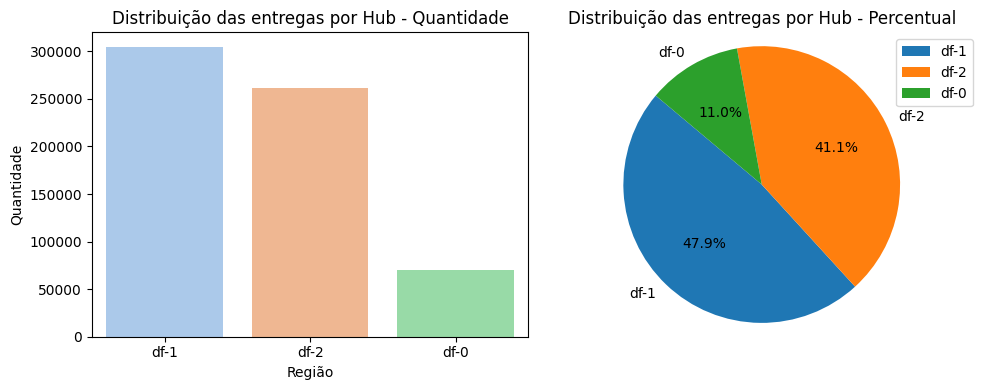

In [ ]:
# Fazer o calculo da distribuição do hub
qtd_hub = pd.DataFrame(entregas_fim_df['region'].value_counts()).reset_index()
qtd_hub = qtd_hub.rename(columns={'index': 'regiao', 'region': 'quantidade'})
qtd_hub['percentual'] = (qtd_hub['quantidade'] / qtd_hub['quantidade'].sum()) * 100

# Configurando o tamanho dos gráficos
plt.figure(figsize=(10, 4))

# Gráfico de barras
plt.subplot(1, 2, 1)
sns.barplot(x='regiao', y='quantidade', data=qtd_hub,  errorbar=None, palette ="pastel", hue='regiao', legend=False)
plt.title('Distribuição das entregas por Hub - Quantidade')
plt.xlabel('Região')
plt.ylabel('Quantidade')

# Gráfico de rosca
plt.subplot(1, 2, 2)
plt.pie(qtd_hub['percentual'], labels=qtd_hub['regiao'], autopct='%1.1f%%', startangle=140)
plt.axis('equal')
plt.title('Distribuição das entregas por Hub - Percentual')
plt.legend(qtd_hub['regiao'], loc="best")

# Mostrando os gráficos
plt.tight_layout()
plt.show()

### **5.2 Mapa com as entregas**



In [ ]:
if os.path.exists('distrito-federal.shp') or os.path.exists('distrito-federal.shxp'):
  print("O arquivo distrito-federal.shp e distrito-federal.shxp já existe")

else:
  !wget -q "https://geoftp.ibge.gov.br/cartas_e_mapas/bases_cartograficas_continuas/bc100/go_df/versao2016/shapefile/bc100_go_df_shp.zip" -O distrito-federal.zip
  !unzip -q distrito-federal.zip -d ./maps
  !cp ./maps/LIM_Unidade_Federacao_A.shp ./distrito-federal.shp
  !cp ./maps/LIM_Unidade_Federacao_A.shx ./distrito-federal.shx
  print("Arquivo distrito-federal.shp e distrito-federal.shxp criado com sucesso")

O arquivo distrito-federal.shp e distrito-federal.shxp já existe


In [ ]:
hub_df = entregas_fim_df[["region", "hub_lng", "hub_lat"]].drop_duplicates().reset_index(drop=True)
geo_hub_df = geopandas.GeoDataFrame(hub_df, geometry=geopandas.points_from_xy(hub_df["hub_lng"], hub_df["hub_lat"]))
geo_hub_df.head()

,region,hub_lng,hub_lat,geometry
0,df-2,-48.054989,-15.838145,POINT (-48.05499 -15.83814)
1,df-1,-47.893662,-15.805118,POINT (-47.89366 -15.80512)
2,df-0,-47.802665,-15.657014,POINT (-47.80266 -15.65701)


In [ ]:
geo_deliveries_df = geopandas.GeoDataFrame(entregas_fim_df, geometry=geopandas.points_from_xy(entregas_fim_df["delivery_lng"], entregas_fim_df["delivery_lat"]))
geo_deliveries_df.head()

,name,region,hub_lng,hub_lat,hub_city,hub_suburb,delivery_size,delivery_lng,delivery_lat,delivery_city,delivery_suburb,geometry
0,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,9,-48.116189,-15.848929,Ceilândia,P Sul,POINT (-48.11619 -15.84893)
1,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,2,-48.118195,-15.850772,Ceilândia,P Sul,POINT (-48.11819 -15.85077)
2,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,1,-48.112483,-15.847871,Ceilândia,P Sul,POINT (-48.11248 -15.84787)
3,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,2,-48.118023,-15.846471,Ceilândia,P Sul,POINT (-48.11802 -15.84647)
4,cvrp-2-df-33,df-2,-48.054989,-15.838145,Taguatinga,Taguatinga,7,-48.114898,-15.858055,Sol Nascente/Pôr do Sol,Sol Nascente/Pôr do Sol,POINT (-48.11490 -15.85805)


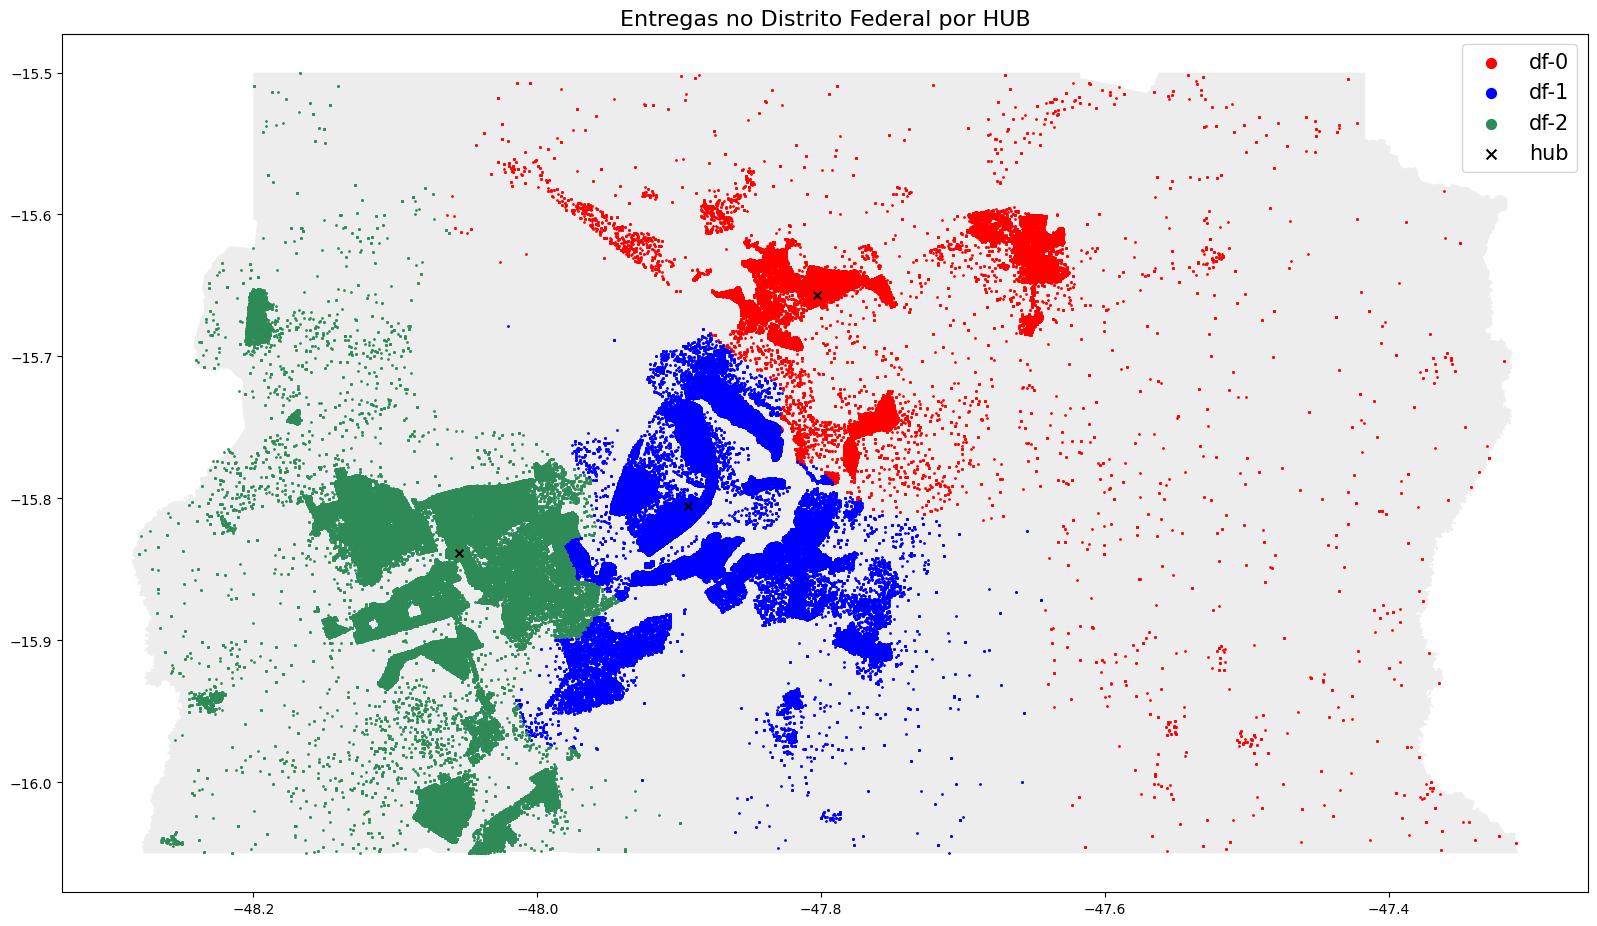

In [ ]:
# cria o plot vazio
fig, ax = plt.subplots(figsize = (50/2.54, 50/2.54))

# plot mapa do distrito federal
mapa = geopandas.read_file("distrito-federal.shp")
mapa = mapa.loc[[0]]
mapa.plot(ax=ax, alpha=0.4, color="lightgrey")

# plot das entregas
geo_deliveries_df.query("region == 'df-0'").plot(ax=ax, markersize=1, color="red", label="df-0")
geo_deliveries_df.query("region == 'df-1'").plot(ax=ax, markersize=1, color="blue", label="df-1")
geo_deliveries_df.query("region == 'df-2'").plot(ax=ax, markersize=1, color="seagreen", label="df-2")

# plot dos hubs
geo_hub_df.plot(ax=ax, markersize=30, marker="x", color="black", label="hub")

# plot da legenda
plt.title("Entregas no Distrito Federal por HUB", fontdict={"fontsize": 16})
lgnd = plt.legend(prop={"size": 15})
for handle in lgnd.legend_handles:
    handle.set_sizes([50])

### **5.3 Insights**

Após analisar os graficos, chegamos a conclusão que:

1.   A maior quantidade de entregas é realizada pelo HUB **df_1** e **df_2** que representa **89%** das entregas realizada
2.   Os HUB estão localizado em pontos estrategicos para realizar as entregas onde existe uma maior demanda e de maneira mais rápida
3.   O HUB **df-0** tem menos entregas, porém, é o HUB que realiza as entrega mais longe





